## Setup

### Install the TensorFlow Model Garden pip package

*  `tf-models-official` is the stable Model Garden package. Note that it may not include the latest changes in the `tensorflow_models` github repo. To include latest changes, you may install `tf-models-nightly`,
which is the nightly Model Garden package created daily automatically.
*  pip will install all models and dependencies automatically.

In [2]:
!pip install -q tf-models-official==2.3.0

     |████████████████████████████████| 849kB 8.5MB/s 
     |████████████████████████████████| 358kB 27.9MB/s 
     |████████████████████████████████| 174kB 35.6MB/s 
     |████████████████████████████████| 102kB 13.1MB/s 
     |████████████████████████████████| 37.6MB 80kB/s 
     |████████████████████████████████| 1.2MB 41.3MB/s 


### Imports

In [3]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Resources

This directory contains the configuration, vocabulary, and a pre-trained checkpoint used in this tutorial:

In [4]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

## The data

In [5]:
from sklearn.model_selection import train_test_split
import pandas as pd

In [6]:
hm = pd.read_csv('/content/drive/MyDrive/Happiness-prediction/hm_train.csv')
hm = hm.sample(frac=1).reset_index(drop=True)

X = hm['cleaned_hm'].values
y = hm['predicted_category'].values

# Splitting out test data
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.25, random_state=42)

The seven classes are:

In [7]:
np.unique(y_train)

array(['achievement', 'affection', 'bonding', 'enjoy_the_moment',
       'exercise', 'leisure', 'nature'], dtype=object)

### The BERT tokenizer

To fine tune a pre-trained model you need to be sure that you're using exactly the same tokenization, vocabulary, and index mapping as you used during training.

The BERT tokenizer used in this tutorial is written in pure Python (It's not built out of TensorFlow ops). So you can't just plug it into your model as a `keras.layer` like you can with `preprocessing.TextVectorization`.

The following code rebuilds the tokenizer that was used by the base model:

In [8]:
# Set up tokenizer to generate Tensorflow dataset
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


Tokenize a sentence:

In [9]:
tokens = tokenizer.tokenize("Hello TensorFlow!")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

['hello', 'tensor', '##flow', '!']
[7592, 23435, 12314, 999]


### Preprocess the data

The section manually preprocessed the dataset into the format expected by the model.

This dataset is small, so preprocessing can be done quickly and easily in memory. For larger datasets the `tf_models` library includes some tools for preprocessing and re-serializing a dataset. See [Appendix: Re-encoding a large dataset](#re_encoding_tools) for details.

#### Encode the sentences

The model expects its two inputs sentences to be concatenated together. This input is expected to start with a `[CLS]` "This is a classification problem" token, and each sentence should end with a `[SEP]` "Separator" token:

In [10]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

Start by encoding all the sentences while appending a `[SEP]` token, and packing them into ragged-tensors:

In [11]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

sentence1 = tf.ragged.constant([
    encode_sentence(s) for s in X_train])

In [12]:
print("Sentence1 shape:", sentence1.shape.as_list())

Sentence1 shape: [36192, None]


Now prepend a `[CLS]` token, and concatenate the ragged tensors to form a single `input_word_ids` tensor for each example. `RaggedTensor.to_tensor()` zero pads to the longest sequence.

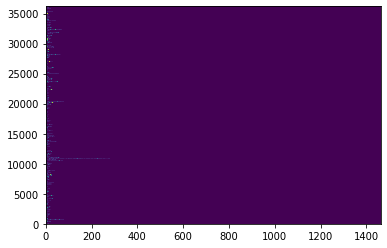

In [13]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
input_word_ids = tf.concat([cls, sentence1], axis=-1)
_ = plt.pcolormesh(input_word_ids.to_tensor())

#### Mask and input type

The model expects two additional inputs:

* The input mask
* The input type

The mask allows the model to cleanly differentiate between the content and the padding. The mask has the same shape as the `input_word_ids`, and contains a `1` anywhere the `input_word_ids` is not padding.

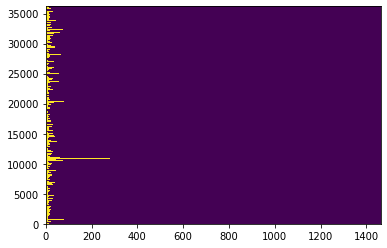

In [14]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

The "input type" also has the same shape, but inside the non-padded region, contains a `0` or a `1` indicating which sentence the token is a part of. 

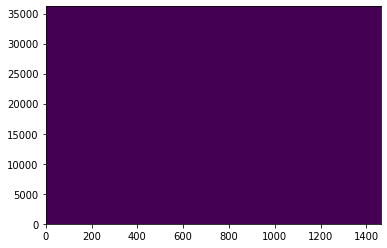

In [15]:
type_cls = tf.zeros_like(cls)
type_s1 = tf.zeros_like(sentence1)
input_type_ids = tf.concat([type_cls, type_s1], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

#### Put it all together

Collect the above text parsing code into a single function, and apply it to each split of the dataset.

In [16]:
def encode_sentence(s, tokenizer, max_seq_length):
   tokens = list(tokenizer.tokenize(s))
   if(len(tokens)>max_seq_length-2):
     tokens = tokens[:max_seq_length-3]
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(data, tokenizer, max_seq_length):
  num_examples = len(data)
  
  sentence1 = tf.ragged.constant([
      encode_sentence(s, tokenizer, max_seq_length)
      for s in data])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
  input_word_ids = tf.concat([cls, sentence1], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
  input_type_ids = tf.concat(
      [type_cls, type_s1], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [17]:
train = bert_encode(X_train, tokenizer, max_seq_length=128)
train_labels = y_train

validation = bert_encode(X_cv, tokenizer, max_seq_length=128)
validation_labels = y_cv

test = bert_encode(X_test, tokenizer, max_seq_length=128)
test_labels  = y_test

Each subset of the data has been converted to a dictionary of features, and a set of labels. Each feature in the input dictionary has the same shape, and the number of labels should match:

In [ ]:
for key, value in train.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'train_labels shape: {train_labels.shape}')

## The model

### Build the model


The first step is to download the configuration  for the pre-trained model.


In [ ]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

The `config` defines the core BERT Model, which is a Keras model to predict the outputs of `num_classes` from the inputs with maximum sequence length `max_seq_length`.

This function returns both the encoder and the classifier.

In [20]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(
    bert_config, num_labels=7)

The classifier has three inputs and one output:

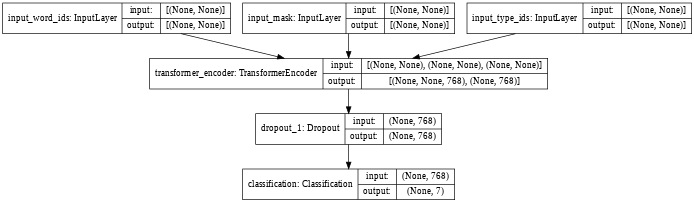

In [21]:
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=48)

Run it on a test batch of data 10 examples from the training set. The output is the logits for the two classes:

In [22]:
batch = {key: val[:10] for key, val in train.items()}

bert_classifier(
    batch, training=True
).numpy()

array([[-0.16827151,  0.09445365, -0.1250355 , -0.13507591, -0.31652293,
         0.28460845,  0.03898121],
       [ 0.09085625, -0.00274688,  0.06279959, -0.08558518, -0.3162126 ,
         0.17182174,  0.18302205],
       [ 0.00127508, -0.16868035, -0.10184933, -0.22363323, -0.30169043,
         0.14520562, -0.08618841],
       [-0.09390322,  0.01069724, -0.10812154, -0.10328165, -0.18824962,
         0.03196074, -0.04455437],
       [-0.24448006, -0.30982986,  0.01843985, -0.08917997, -0.25216094,
        -0.09019475,  0.1166108 ],
       [-0.18560584, -0.04629901, -0.09182698, -0.02980077, -0.35611755,
        -0.06764972,  0.13474146],
       [-0.08185335, -0.0683575 ,  0.05927845, -0.26925474, -0.25914207,
         0.20070887,  0.02668354],
       [-0.06553656, -0.05298815,  0.07275144, -0.14371155, -0.28674647,
         0.16249232, -0.09828932],
       [ 0.05545853, -0.00095854, -0.01238264, -0.06113209, -0.14431483,
         0.20264022,  0.19945425],
       [-0.27992737,  0.1516

The `TransformerEncoder` in the center of the classifier above **is** the `bert_encoder`.

Inspecting the encoder, we see its stack of `Transformer` layers connected to those same three inputs:

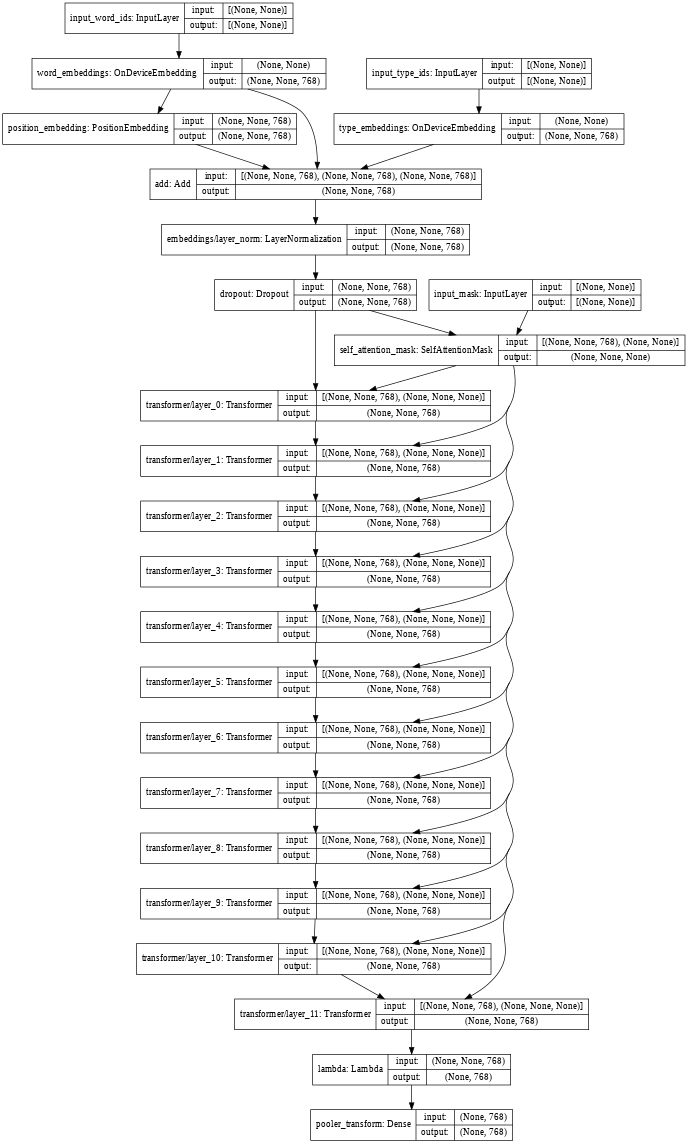

In [23]:
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=48)

### Restore the encoder weights

When built the encoder is randomly initialized. Restore the encoder's weights from the checkpoint:

In [24]:
checkpoint = tf.train.Checkpoint(model=bert_encoder)
checkpoint.restore(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

Note: The pretrained `TransformerEncoder` is also available on [TensorFlow Hub](https://tensorflow.org/hub). See the [Hub appendix](#hub_bert) for details. 

### Set up the optimizer

BERT adopts the Adam optimizer with weight decay (aka "[AdamW](https://arxiv.org/abs/1711.05101)").
It also employs a learning rate schedule that firstly warms up from 0 and then decays to 0.

In [25]:
# Set up epochs and steps
epochs = 2
batch_size = 32
eval_batch_size = 32

train_data_size = len(train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

This returns an `AdamWeightDecay`  optimizer with the learning rate schedule set:

In [26]:
type(optimizer)

official.nlp.optimization.AdamWeightDecay

To see an example of how to customize the optimizer and it's schedule, see the [Optimizer schedule appendix](#optiizer_schedule).

### Train the model

The metric is accuracy and we use sparse categorical cross-entropy as loss.

In [27]:
from sklearn.preprocessing import LabelEncoder

In [28]:
le = LabelEncoder()
train_labels_enc = le.fit_transform(train_labels)
validation_labels_enc = le.transform(validation_labels)
test_labels_enc = le.transform(test_labels)

In [29]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

bert_classifier.fit(
      train, train_labels_enc,
      validation_data=(validation, validation_labels_enc),
      batch_size=32,
      epochs=epochs)

Epoch 1/2
1131/1131 [==============================] - 976s 855ms/step - loss: 0.9471 - accuracy: 0.6626 - val_loss: 0.3479 - val_accuracy: 0.8808
Epoch 2/2
1131/1131 [==============================] - 967s 855ms/step - loss: 0.2735 - accuracy: 0.9068 - val_loss: 0.3142 - val_accuracy: 0.8921


Now run the fine-tuned model on a custom example to see that it works.

Start by encoding some sentence pairs:

In [30]:
bert_classifier.evaluate(test, test_labels_enc)

378/378 [==============================] - 100s 262ms/step - loss: 0.3176 - accuracy: 0.8908


[0.31756821274757385, 0.8907583951950073]

In [31]:
export_dir='/content/drive/MyDrive/Happiness-prediction/saved_model'
tf.saved_model.save(bert_classifier, export_dir=export_dir)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Happiness-prediction/saved_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Happiness-prediction/saved_model/assets


In [32]:
reloaded = tf.saved_model.load(export_dir)

In [33]:
hm_test = pd.read_csv('/content/drive/MyDrive/Happiness-prediction/hm_test.csv')
submission_examples = bert_encode(hm_test['cleaned_hm'].values,tokenizer=tokenizer, max_seq_length=128)

In [37]:
results = bert_classifier.predict(submission_examples)

In [44]:
results_classes = tf.argmax(results, axis=-1).numpy()

In [50]:
# Converting back to named classes & saving results
pred = pd.DataFrame({'predicted_category': le.inverse_transform(results_classes)})
data_pred = pd.concat([hm_test, pred], axis=1)

In [51]:
data_pred.head()

,hmid,reflection_period,cleaned_hm,num_sentence,predicted_category
0,88305,3m,I spent the weekend in Chicago with my friends.,1,bonding
1,88306,3m,We moved back into our house after a remodel. ...,2,achievement
2,88307,3m,My fiance proposed to me in front of my family...,1,affection
3,88308,3m,I ate lobster at a fancy restaurant with some ...,1,bonding
4,88309,3m,I went out to a nice restaurant on a date with...,5,affection


In [52]:
data_pred.to_csv('/content/drive/MyDrive/Happiness-prediction/hm_predictions.csv')